In [41]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
import spacy
import os

In [42]:
pd.options.mode.chained_assignment = None
nltk.download('stopwords')

file_prefix = 'hashtag'
text_field = 'hashtag'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
# csvname="filtered_dataset/"+file_prefix+".csv" #changed
csvname=file_prefix+".csv" #changed
data_orig=pd.read_csv(csvname)
data=data_orig.copy()
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(data)

In [44]:
def filter_text(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    oldtext=data[text_field][i] 
    newtext=' '.join(re.sub("(@[A-Za-z0-9]+)| (_URL_) | (#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",str(oldtext)).split()) # removes hashtags, https links, usernames.
    newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext)) #removes all other characters other than English Alpha-Numeric Characters
    newtext=newtext.lower()
    newtext=newtext.split()
    data[text_field][i]=newtext
  return data

In [45]:
filtered_data=filter_text(data)
filtered_data

,hashtag,class
0,"[aidsmaplive, monkeypox]",0
1,[nan],0
2,"[healthcare, monkeypox]",0
3,[nan],0
4,[nan],0
...,...,...
5782,[nan],1
5783,[nan],1
5784,[nan],1
5785,[nan],1


In [46]:
def porterstemming(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    ps=PorterStemmer()
    oldtext=data[text_field][i]
    newtext= [ps.stem(word) for word in oldtext if word not in set(stopwords.words('english'))]
    newtext=' '.join(newtext)
    data[text_field][i]=newtext
  return data

In [47]:
portered_stemmed_data=porterstemming(filtered_data)
portered_stemmed_data

,hashtag,class
0,aidsmapl monkeypox,0
1,nan,0
2,healthcar monkeypox,0
3,nan,0
4,nan,0
...,...,...
5782,nan,1
5783,nan,1
5784,nan,1
5785,nan,1


In [48]:
def lemmatization(in_data):
  data = in_data.copy()
  spc = spacy.load("en_core_web_sm")
  for i in range (0,rows):
    oldtext = ' '.join(item for item in data[text_field][i])
    doc = spc(oldtext)
    newtext=' '.join([str(token) for token in doc if token not in set(stopwords.words("english"))])
    newtext = re.sub(r'\s+', ' ', newtext)
    data[text_field][i]=newtext
  return data

In [49]:
lemmatization_data=lemmatization(filtered_data)
lemmatization_data

,hashtag,class
0,aidsmaplive monkeypox,0
1,nan,0
2,healthcare monkeypox,0
3,nan,0
4,nan,0
...,...,...
5782,nan,1
5783,nan,1
5784,nan,1
5785,nan,1


In [50]:
def create_corpus_and_y(data):
  y=np.array(data["class"])
  corpus=[data[text_field][i] for i in range(len(data)) if len(data)!=0]
  return (y,corpus)

In [51]:
y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

In [52]:
def count_vec(corpus):
  from sklearn.feature_extraction.text import CountVectorizer
  cv = CountVectorizer(max_features = 1500)
  X = cv.fit_transform(corpus).toarray()
  return X

In [53]:
def tf_idf_vec(corpus):
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(max_features=1500) # Add min_df, max_df parameters as well
  vectorizer.fit(corpus)
  X = vectorizer.transform(corpus)
  X=X.toarray()
  return X

In [54]:
X_portered_CV=count_vec(portered_corpus)
X_lemmatization_CV=count_vec(lemmatization_corpus)

In [55]:
df_portered_CV = pd.DataFrame(X_portered_CV)
df_portered_CV['class'] = y_portered
df_portered_CV

,0,1,2,3,4,5,6,7,8,9,...,739,740,741,742,743,744,745,746,747,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
df_lemmatization_CV = pd.DataFrame(X_lemmatization_CV)
df_lemmatization_CV['class'] = y_lemmatization
df_lemmatization_CV

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [57]:
X_portered_TF_IDF=count_vec(portered_corpus)
X_lemmatization_TF_IDF=count_vec(lemmatization_corpus)

In [58]:
df_portered_TF_IDF = pd.DataFrame(X_portered_TF_IDF)
df_portered_TF_IDF['class'] = y_portered
df_portered_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,739,740,741,742,743,744,745,746,747,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [59]:
df_lemmatization_TF_IDF = pd.DataFrame(X_lemmatization_TF_IDF)
df_lemmatization_TF_IDF['class'] = y_lemmatization
df_lemmatization_TF_IDF

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [60]:
#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df_portered_CV.to_csv('processed_dataset/'+file_prefix+'_portered_CV.csv',index=False) 
df_lemmatization_CV.to_csv('processed_dataset/'+file_prefix+'_lemmatization_CV.csv',index=False)

In [61]:
df_portered_TF_IDF.to_csv('processed_dataset/'+file_prefix+'_portered_TF_IDF.csv',index=False) 
df_lemmatization_TF_IDF.to_csv('processed_dataset/'+file_prefix+'_lemmatization_TF_IDF.csv',index=False)

#PCA starts

In [62]:
def split_data_train_test_split(X,y):
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
 return(X_train, X_test,y_train,y_test)

In [63]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  # print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  #plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print (csum[n_components])

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [64]:
# PCA on lemmatization data
y = df_lemmatization_TF_IDF['class']
X_lemmatization_tf = df_lemmatization_TF_IDF.copy()
X_lemmatization_tf.drop ('class', axis=1, inplace=True)

X_lemmatization_cv = df_lemmatization_CV.copy()
X_lemmatization_cv.drop ('class', axis=1, inplace=True)

In [65]:
X_train_cv, X_test_cv,y_train_cv,y_test_cv=split_data_train_test_split(X_lemmatization_cv,y)
X_train_tf, X_test_tf,y_train_tf,y_test_tf=split_data_train_test_split(X_lemmatization_tf,y)

Variance explained by all 770 principal components = 100.00000000000028

99.45981938925105
300



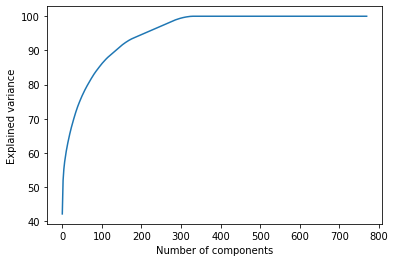

In [66]:
# PCA lemmatization CV
X_train_ = X_train_cv
y_train_ = y_train_cv
total_components = min(len(df_lemmatization_CV.columns)-1, len(X_train_))
n_components = 300
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)

Variance explained by all 770 principal components = 100.00000000000028

99.45981938925105
300



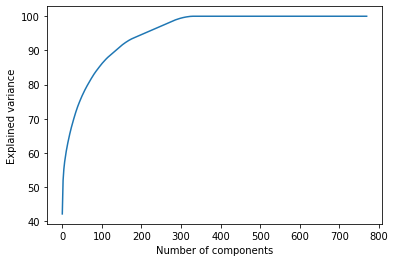

In [67]:
# PCA lemmatization TF IDF
X_train_ = X_train_tf
y_train_ = y_train_tf
total_components = min(len(df_lemmatization_TF_IDF.columns)-1, len(X_train_))
n_components = 300
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)

In [68]:
# PCA on portered data
y = df_portered_TF_IDF['class']
X_portered_tf = df_portered_TF_IDF.copy()
X_portered_tf.drop ('class', axis=1, inplace=True)

X_portered_cv = df_portered_CV.copy()
X_portered_cv.drop ('class', axis=1, inplace=True)

In [69]:
X_train_cv, X_test_cv,y_train_cv,y_test_cv=split_data_train_test_split(X_portered_cv,y)
X_train_tf, X_test_tf,y_train_tf,y_test_tf=split_data_train_test_split(X_portered_tf,y)

Variance explained by all 748 principal components = 100.0000000000006

99.58697141982277
300



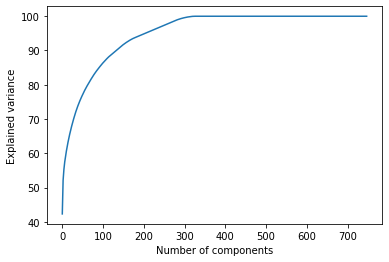

In [70]:
# PCA portered CV
X_train_ = X_train_cv
y_train_ = y_train_cv
total_components = min(len(df_portered_CV.columns)-1, len(X_train_))
n_components = 300
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)

Variance explained by all 748 principal components = 100.0000000000006

99.58697141982277
300



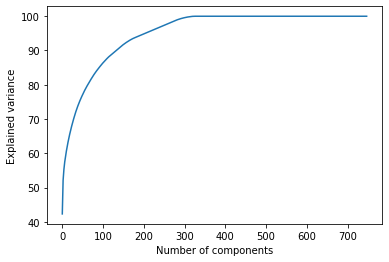

In [71]:
# PCA portered TF IDF
X_train_ = X_train_tf
y_train_ = y_train_tf
total_components = min(len(df_portered_TF_IDF.columns)-1, len(X_train_))
n_components = 300
X_train = perform_PCA (X_train_, y_train_, total_components, n_components)